# Relationships between variables

So far we have only looked at one variable at a time. In this chapter we
look at relationships between variables. Two variables are related if
knowing one gives you information about the other. For example, height
and weight are related; people who are taller tend to be heavier. Of
course, it is not a perfect relationship: there are short heavy people
and tall light ones. But if you are trying to guess someone's weight,
you will be more accurate if you know their height than if you don't.

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2


<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkplot.py")

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import thinkplot

<IPython.core.display.Javascript object>

## Scatter plots

The simplest way to check for a relationship between two variables is a
**scatter plot**, but making a good scatter plot is not always easy. As
an example, I'll plot weight versus height for the respondents in the
BRFSS (see Section [\[lognormal\]](#lognormal){reference-type="ref"
reference="lognormal"}).

Here's the code that reads the data file and extracts height and weight:

In [4]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/brfss.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/CDBRFS08.ASC.gz")

<IPython.core.display.Javascript object>

In [5]:
import brfss

df = brfss.read_brfss(nrows=None)

<IPython.core.display.Javascript object>

To choose a random subset of the data, we'll use the `DataFrame` method `sample` with the keyword argument `replace=False`, which means that no row can appear in the sample more than once.

In [6]:
sample = df.sample(5000, replace=False)
heights, weights = sample.htm3, sample.wtkg2

<IPython.core.display.Javascript object>

`thinkplot` provides `scatter`, which makes scatter plots.
Here's a scatter plot of weight versus height.

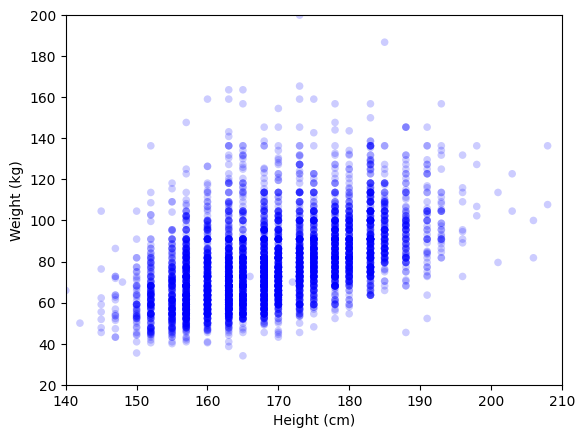

<IPython.core.display.Javascript object>

In [7]:
thinkplot.scatter(heights, weights)
thinkplot.config(xlabel="Height (cm)", ylabel="Weight (kg)", axis=[140, 210, 20, 200])

The scatter plot shows the shape of the relationship -- taller people tend to be heavier.

But this is not the best representation of the data, because the data
are packed into columns. The problem is that the heights are rounded to
the nearest inch, converted to centimeters, and then rounded again. Some
information is lost in translation.

We can't get that information back, but we can minimize the effect on
the scatter plot by **jittering** the data, which means adding random
noise to reverse the effect of rounding off. 

In [8]:
def jitter(seq, std=0.5):
    """Jitters the values by adding random Gaussian noise.

    seq: sequence of numbers
    std: standard deviation of the added noise

    returns: new Numpy array
    """
    n = len(seq)
    return np.random.normal(0, std, n) + seq

<IPython.core.display.Javascript object>

The values can be any sequence; the result is a NumPy array.

In [9]:
heights_jittered = jitter(heights, 1.3)
weights_jittered = jitter(weights, 0.5)

<IPython.core.display.Javascript object>

Since these measurements
were rounded to the nearest inch, they might be off by up to 0.5 inches
or 1.3 cm. Similarly, the weights might be off by 0.5 kg.

The following figure shows the result. 

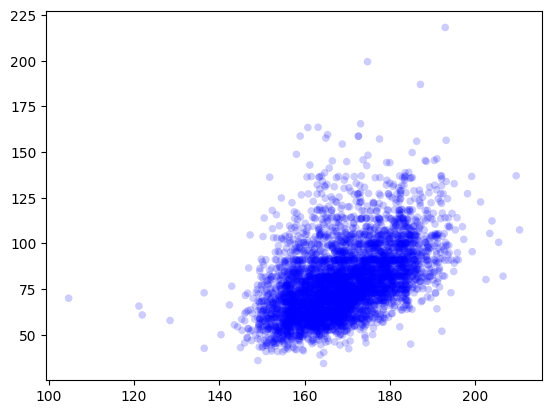

<IPython.core.display.Javascript object>

In [10]:
thinkplot.scatter(heights_jittered, weights_jittered)

Jittering reduces the
visual effect of rounding and makes the shape of the relationship
clearer. But in general you should only jitter data for purposes of
visualization and avoid using jittered data for analysis.

Even with jittering, this is not the best way to represent the data.
There are many overlapping points, which hides data in the dense parts
of the figure and gives disproportionate emphasis to outliers. This
effect is called **saturation**.

We can solve this problem with the `alpha` parameter, which makes the
points partly transparent:

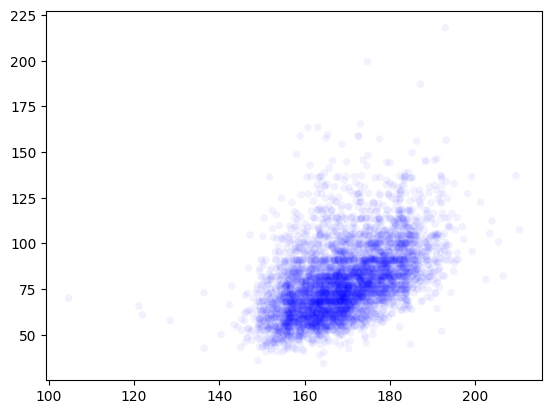

<IPython.core.display.Javascript object>

In [11]:
thinkplot.scatter(heights_jittered, weights_jittered, alpha=0.05)

With transparency, overlapping data points
look darker, so darkness is proportional to density. 
In this version of
the plot we can see a detail that were not apparent before: a horizontal line near 90 kg or 200
pounds.
Since this data is based on self-reports in pounds, the most
likely explanation is that some respondents reported rounded values.

Using transparency works well for moderate-sized datasets, but this
figure only shows the first 5000 records in the BRFSS, out of a total of
414 509.

To handle larger datasets, another option is a hexbin plot, which
divides the graph into hexagonal bins and colors each bin according to
how many data points fall in it. `thinkplot` provides `hex_bin`:

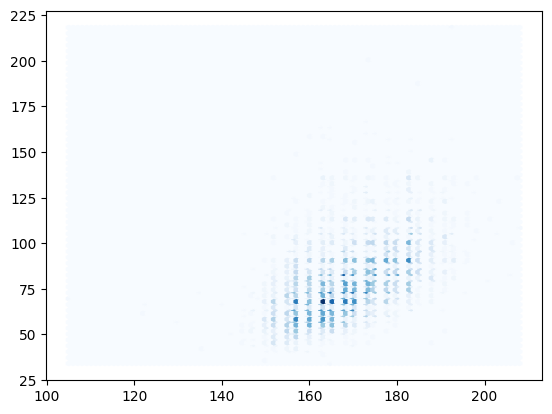

<IPython.core.display.Javascript object>

In [12]:
thinkplot.hex_bin(heights, weights)

An advantage of a hexbin
is that it shows the shape of the relationship well, and it is efficient
for large datasets, both in time and in the size of the file it
generates. A drawback is that it makes the outliers invisible.

The point of this example is that it is not easy to make a scatter plot
that shows relationships clearly without introducing misleading
artifacts.

## Characterizing relationships

Scatter plots provide a general impression of the relationship between
variables, but there are other visualizations that provide more insight
into the nature of the relationship. One option is to bin one variable
and plot percentiles of the other.

NumPy and pandas provide functions for binning data:

In [13]:
df = df.dropna(subset=["htm3", "wtkg2"])
bins = np.arange(135, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

<IPython.core.display.Javascript object>

`dropna` drops rows with `nan` in any of the listed columns. `arange`
makes a NumPy array of bins from 135 to, but not including, 210, in
increments of 5.

`digitize` computes the index of the bin that contains each value in
`df.htm3`. The result is a NumPy array of integer indices. Values that
fall below the lowest bin are mapped to index 0. Values above the
highest bin are mapped to `len(bins)`.

`groupby` is a DataFrame method that returns a GroupBy object; used in a
`for` loop, `groups` iterates the names of the groups and the DataFrames
that represent them. So, for example, we can print the number of rows in
each group like this:

In [14]:
for i, group in groups:
    print(i, len(group))

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


<IPython.core.display.Javascript object>

Now for each group we can compute the mean height and the CDF of weight:

In [15]:
from thinkstats import Cdf

height_means = [group.htm3.mean() for i, group in groups]
cdfs = [Cdf(group.wtkg2) for i, group in groups]

<IPython.core.display.Javascript object>

Finally, we can plot percentiles of weight versus height:

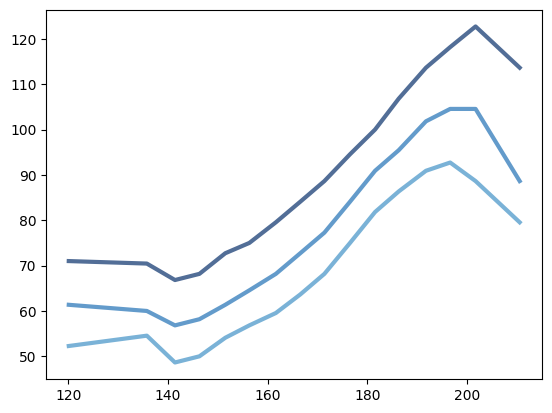

<IPython.core.display.Javascript object>

In [16]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.percentile(percent) for cdf in cdfs]
    label = "%dth" % percent
    thinkplot.plot(height_means, weight_percentiles, label=label)

The following figure shows the result. Between 140 and 200 cm the
relationship between these variables is roughly linear. This range
includes more than 99% of the data, so we don't have to worry too much
about the extremes.

## Correlation

A **correlation** is a statistic intended to quantify the strength of
the relationship between two variables.

A challenge in measuring correlation is that the variables we want to
compare are often not expressed in the same units. And even if they are
in the same units, they come from different distributions.

There are two common solutions to these problems:

1.  Transform each value to a **standard score**, which is the number of
    standard deviations from the mean. This transform leads to the
    "Pearson product-moment correlation coefficient."

2.  Transform each value to its **rank**, which is its index in the
    sorted list of values. This transform leads to the "Spearman rank
    correlation coefficient."

If $X$ is a series of $n$ values, $x_i$, we can convert to standard
scores by subtracting the mean and dividing by the standard deviation:
$z_i = (x_i - \mu) / \sigma$.

The numerator is a deviation: the distance from the mean. Dividing by
$\sigma$ **standardizes** the deviation, so the values of $Z$ are
dimensionless (no units) and their distribution has mean 0 and variance
1.

If $X$ is normally distributed, so is $Z$. But if $X$ is skewed or has
outliers, so does $Z$; in those cases, it is more robust to use
percentile ranks. If we compute a new variable, $R$, so that $r_i$ is
the rank of $x_i$, the distribution of $R$ is uniform from 1 to $n$,
regardless of the distribution of $X$.

## Covariance

**Covariance** is a measure of the tendency of two variables to vary
together. If we have two series, $X$ and $Y$, their deviations from the
mean are 

$$dx_i = x_i - \bar{x}$$ 

$$dy_i = y_i - \bar{y}$$ 

where $\bar{x}$ is
the sample mean of $X$ and $\bar{y}$ is the sample mean of $Y$. If $X$ and
$Y$ vary together, their deviations tend to have the same sign.

If we multiply them together, the product is positive when the
deviations have the same sign and negative when they have the opposite
sign. So adding up the products gives a measure of the tendency to vary
together.

Covariance is the mean of these products:

$$Cov(X,Y) = \frac{1}{n} \sum dx_i~dy_i$$ 

where $n$ is the length of the
two series (they have to be the same length).

If you have studied linear algebra, you might recognize that `cov` is
the dot product of the deviations, divided by their length. So the
covariance is maximized if the two vectors are identical, 0 if they are
orthogonal, and negative if they point in opposite directions.

In [17]:
def cov(xs, ys):
    xbar = np.mean(xs)
    ybar = np.mean(ys)
    dx = xs - xbar
    dy = ys - ybar
    cov = np.sum(dx * dy) / len(xs)
    return cov

<IPython.core.display.Javascript object>

This implementation of covariance is meant to be simple for purposes of
explanation. NumPy and Pandas also provide implementations of
covariance, but Pandas applies a correction for small sample sizes
that we have not covered yet, 
and NumPy returns a covariance matrix,
which is more than we need for now.

In [18]:
cov(heights, weights)

91.17851388432973

<IPython.core.display.Javascript object>

TODO: What does it mean? Nothing. Note the units.

## Pearson's correlation

Covariance is useful in some computations, but it is seldom reported as
a summary statistic because it is hard to interpret. Among other
problems, its units are the product of the units of $X$ and $Y$. For
example, the covariance of weight and height in the BRFSS dataset is 113
kilogram-centimeters, whatever that means.

One solution to this problem is to divide the deviations by the standard
deviation, which yields standard scores, and compute the product of
standard scores:

$$p_i = \frac{(x_i - \bar{x})}{S_X} \frac{(y_i - \bar{y})}{S_Y}$$ 

Where $S_X$ and $S_Y$ are the standard deviations of $X$ and $Y$. The mean of
these products is $$\rho = \frac{1}{n} \sum p_i$$ 

Or we can rewrite $\rho$ by factoring out $S_X$ and $S_Y$:

$$\rho = \frac{Cov(X,Y)}{S_X S_Y}$$

This value is called **Pearson's
correlation** after Karl Pearson, an influential early statistician. It
is easy to compute and easy to interpret. Because standard scores are
dimensionless, so is $\rho$.

Here's a function that computes correlations.

In [19]:
def corr(xs, ys):
    sx = np.std(xs)
    sy = np.std(ys)
    corr = cov(xs, ys) / sx / sy
    return corr

<IPython.core.display.Javascript object>

Pearson's correlation is always between -1 and +1 (including both). If
$\rho$ is positive, we say that the correlation is positive, which means
that when one variable is high, the other tends to be high. If $\rho$ is
negative, the correlation is negative, so when one variable is high, the
other is low.

The magnitude of $\rho$ indicates the strength of the correlation. If
$\rho$ is 1 or -1, the variables are perfectly correlated, which means
that if you know one, you can make a perfect prediction about the other.

In [20]:
corr(heights, weights)

0.4687022137574756

<IPython.core.display.Javascript object>

Most correlation in the real world is not perfect, but it is still
useful. The correlation of height and weight is 0.51, which is a strong
correlation compared to similar human-related variables.

## Nonlinear relationships

If Pearson's correlation is near 0, it is tempting to conclude that
there is no relationship between the variables, but that conclusion is
not valid. Pearson's correlation only measures *linear* relationships.
If there's a nonlinear relationship, $\rho$ understates its strength.

The following figure is from
<http://wikipedia.org/wiki/Correlation_and_dependence>. It shows scatter
plots and correlation coefficients for several carefully constructed
datasets.

In [21]:
# TODO insert figure

<IPython.core.display.Javascript object>

The top row shows linear relationships with a range of correlations; you
can use this row to get a sense of what different values of $\rho$ look
like. The second row shows perfect correlations with a range of slopes,
which demonstrates that correlation is unrelated to slope (we'll talk
about estimating slope soon). The third row shows variables that are
clearly related, but because the relationship is nonlinear, the
correlation coefficient is 0.

The moral of this story is that you should always look at a scatter plot
of your data before blindly computing a correlation coefficient.

## Spearman's rank correlation

Pearson's correlation works well if the relationship between variables
is linear and if the variables are roughly normal. But it is not robust
in the presence of outliers. Spearman's rank correlation is an
alternative that mitigates the effect of outliers and skewed
distributions. To compute Spearman's correlation, we have to compute the
**rank** of each value, which is its index in the sorted sample. For
example, in the sample `[5, 1, 2, 7]` the rank of the value 5 is 3,
because it appears third in the sorted list.

To compute ranks...





In [22]:
import pandas as pd

t = [5, 1, 2, 7]
pd.Series(t).rank()

0    3.0
1    1.0
2    2.0
3    4.0
dtype: float64

<IPython.core.display.Javascript object>

Then we compute Pearson's correlation for the ranks.

In [23]:
import pandas as pd


def spearman_corr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return corr(xranks, yranks)

<IPython.core.display.Javascript object>

In [24]:
spearman_corr(heights, weights)

0.4987959158394597

<IPython.core.display.Javascript object>

The Spearman rank correlation for the BRFSS data is 0.53, a little
higher than the Pearson correlation, 0.51. There are several possible
reasons for the difference, including:

-   If the relationship is nonlinear, Pearson's correlation tends to
    underestimate the strength of the relationship, and

-   Pearson's correlation can be affected (in either direction) if one
    of the distributions is skewed or contains outliers. Spearman's rank
    correlation is more robust.

In the BRFSS example, we know that the distribution of weights is
roughly lognormal; under a log transform it approximates a normal
distribution, so it has no skew. So another way to eliminate the effect
of skewness is to compute Pearson's correlation with log-weight and
height:

In [25]:
corr(heights, np.log10(weights))

0.4904959779568214

<IPython.core.display.Javascript object>

The result is very close to the rank correlation.
So that suggests that skewness in the distribution of weight explains most of
the difference between Pearson's and Spearman's correlation.

## Correlation and causation

If variables A and B are correlated, there are three possible
explanations: A causes B, or B causes A, or some other set of factors
causes both A and B. These explanations are called "causal
relationships".

Correlation alone does not distinguish between these explanations, so it
does not tell you which ones are true. This rule is often summarized
with the phrase "Correlation does not imply causation," which is so
pithy it has its own Wikipedia page:
<http://wikipedia.org/wiki/Correlation_does_not_imply_causation>.

So what can you do to provide evidence of causation?

1.  Use time. If A comes before B, then A can cause B but not the other
    way around (at least according to our common understanding of
    causation). The order of events can help us infer the direction of
    causation, but it does not preclude the possibility that something
    else causes both A and B.

2.  Use randomness. If you divide a large sample into two groups at
    random and compute the means of almost any variable, you expect the
    difference to be small. If the groups are nearly identical in all
    variables but one, you can eliminate spurious relationships.

This works even if you don't know what the relevant variables are,
but it works even better if you do, because you can check that the
groups are identical.

These ideas are the motivation for the **randomized controlled trial**,
in which subjects are assigned randomly to two (or more) groups: a
**treatment group** that receives some kind of intervention, like a new
medicine, and a **control group** that receives no intervention, or
another treatment whose effects are known.

A randomized controlled trial is the most reliable way to demonstrate a
causal relationship, and the foundation of science-based medicine (see
<http://wikipedia.org/wiki/Randomized_controlled_trial>).

Unfortunately, controlled trials are only possible in the laboratory
sciences, medicine, and a few other disciplines. In the social sciences,
controlled experiments are rare, usually because they are impossible or
unethical.

An alternative is to look for a **natural experiment**, where different
"treatments" are applied to groups that are otherwise similar. One
danger of natural experiments is that the groups might differ in ways
that are not apparent. You can read more about this topic at
<http://wikipedia.org/wiki/Natural_experiment>.

In some cases it is possible to infer causal relationships using
**regression analysis**, which is the topic of
Chapter [\[regression\]](#regression){reference-type="ref"
reference="regression"}.

## Glossary

-   **scatter plot**: A visualization of the relationship between two
    variables, showing one point for each row of data.

-   **jitter**: Random noise added to data for purposes of
    visualization.

-   **saturation**: Loss of information when multiple points are plotted
    on top of each other.

-   **correlation**: A statistic that measures the strength of the
    relationship between two variables.

-   **standardize**: To transform a set of values so that their mean is
    0 and their variance is 1.

-   **standard score**: A value that has been standardized so that it is
    expressed in standard deviations from the mean.

-   **covariance**: A measure of the tendency of two variables to vary
    together.

-   **rank**: The index where an element appears in a sorted list.

-   **randomized controlled trial**: An experimental design in which
    subjects are divided into groups at random, and different groups are
    given different treatments.

-   **treatment group**: A group in a controlled trial that receives
    some kind of intervention.

-   **control group**: A group in a controlled trial that receives no
    treatment, or a treatment whose effect is known.

-   **natural experiment**: An experimental design that takes advantage
    of a natural division of subjects into groups in ways that are at
    least approximately random.

**Exercise:**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatter plot can be tricky.  As an exercise, experiment with `scatter` and `hex_bin` to make a plot that represents the entire dataset well.

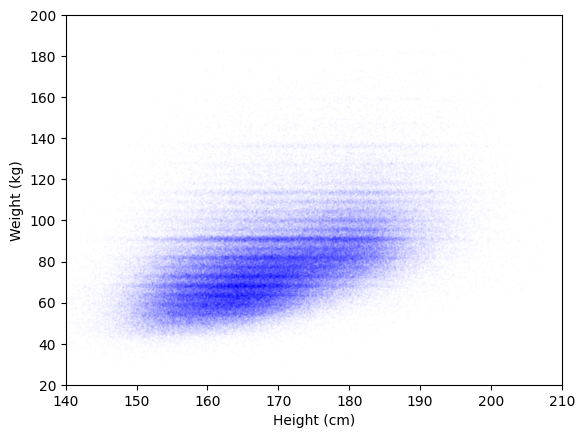

<IPython.core.display.Javascript object>

In [26]:
# Solution

heights = jitter(df.htm3, 2.8)
weights = jitter(df.wtkg2, 1.0)

thinkplot.scatter(heights, weights, alpha=0.01, s=2)
thinkplot.config(xlabel="Height (cm)", ylabel="Weight (kg)", axis=[140, 210, 20, 200])

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.  As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

In [27]:
# Solution

cleaned = df.dropna(subset=["htm3", "wtkg2"])

<IPython.core.display.Javascript object>

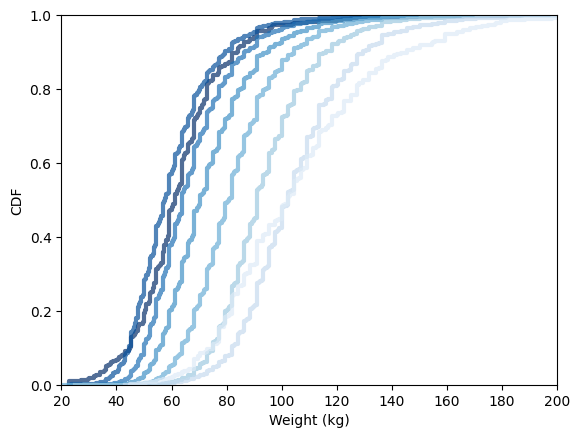

<IPython.core.display.Javascript object>

In [28]:
# Solution

bins = np.arange(140, 210, 10)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)
cdfs = [Cdf(group.wtkg2) for i, group in groups]

thinkplot.pre_plot(len(cdfs))
thinkplot.cdfs(cdfs)
thinkplot.config(xlabel="Weight (kg)", ylabel="CDF", axis=[20, 200, 0, 1])

## Exercises

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [29]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

In [30]:
import nsfg

live, firsts, others = nsfg.make_frames()
live = live.dropna(subset=["agepreg", "totalwgt_lb"])

<IPython.core.display.Javascript object>

In [31]:
# Solution

ages = live.agepreg
weights = live.totalwgt_lb
print("corr", corr(ages, weights))
print("spearman_corr", spearman_corr(ages, weights))

corr 0.0688339703541091
spearman_corr 0.09461004109658228


<IPython.core.display.Javascript object>

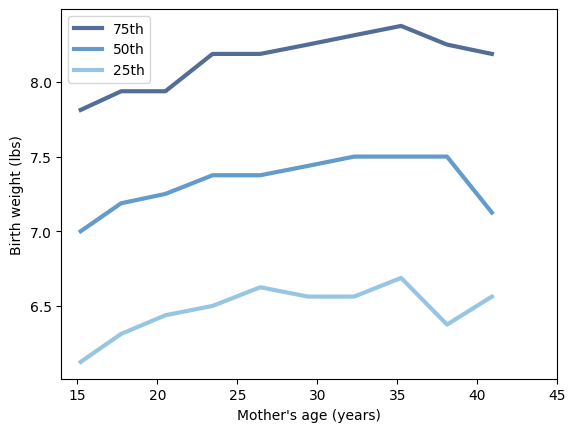

<IPython.core.display.Javascript object>

In [32]:
# Solution


def binned_percentiles(df):
    """Bin the data by age and plot percentiles of weight for each bin.

    df: DataFrame
    """
    bins = np.arange(10, 48, 3)
    indices = np.digitize(df.agepreg, bins)
    groups = df.groupby(indices)
    ages = [group.agepreg.mean() for i, group in groups][1:-1]
    cdfs = [Cdf(group.totalwgt_lb) for i, group in groups][1:-1]
    thinkplot.pre_plot(3)
    for percent in [75, 50, 25]:
        weights = [cdf.percentile(percent) for cdf in cdfs]
        label = "%dth" % percent
        thinkplot.plot(ages, weights, label=label)
    thinkplot.config(
        xlabel="Mother's age (years)",
        ylabel="Birth weight (lbs)",
        xlim=[14, 45],
        legend=True,
    )


binned_percentiles(live)

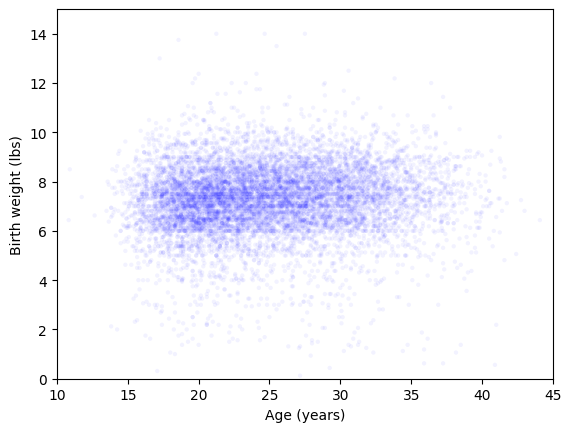

<IPython.core.display.Javascript object>

In [33]:
# Solution

thinkplot.scatter(ages, weights, alpha=0.05, s=10)
thinkplot.config(
    xlabel="Age (years)",
    ylabel="Birth weight (lbs)",
    xlim=[10, 45],
    ylim=[0, 15],
)